Image Demosaicing (ADMM Plug-and-Play Priors w/ BM3D)
======================================================

This example demonstrates the use of the ADMM Plug and Play Priors (PPP) algorithm <cite data-cite="venkatakrishnan-2013-plugandplay2"/> for solving a raw image demosaicing problem.

In [1]:
import numpy as np

import jax

from bm3d import bm3d_rgb
from colour_demosaicing import demosaicing_CFA_Bayer_Menon2007

import scico
import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.data import kodim23
plot.config_notebook_plotting()

Read a ground truth image.

In [2]:
img = kodim23(asfloat=True)[160:416, 60:316]
img = jax.device_put(img)  # Convert to jax type, push to GPU

Define demosaicing forward operator and its transpose.

In [3]:
def Afn(x):
    """Map an RGB image to a single channel image with each pixel
    representing a single colour according to the colour filter array.
    """

    y = snp.zeros(x.shape[0:2])
    y = y.at[1::2, 1::2].set(x[1::2, 1::2, 0])
    y = y.at[0::2, 1::2].set(x[0::2, 1::2, 1])
    y = y.at[1::2, 0::2].set(x[1::2, 0::2, 1])
    y = y.at[0::2, 0::2].set(x[0::2, 0::2, 2])
    return y


def ATfn(x):
    """Back project a single channel raw image to an RGB image with zeros
    at the locations of undefined samples.
    """

    y = snp.zeros(x.shape + (3,))
    y = y.at[1::2, 1::2, 0].set(x[1::2, 1::2])
    y = y.at[0::2, 1::2, 1].set(x[0::2, 1::2])
    y = y.at[1::2, 0::2, 1].set(x[1::2, 0::2])
    y = y.at[0::2, 0::2, 2].set(x[0::2, 0::2])
    return y

Define a baseline demosaicing function based on the demosaicing algorithm of <cite data-cite="menon-2007-demosaicing"/> from package [colour_demosaicing](https://github.com/colour-science/colour-demosaicing).

In [4]:
def demosaic(cfaimg):
    return demosaicing_CFA_Bayer_Menon2007(cfaimg, pattern="BGGR").astype(np.float32)

Create a test image by color filter array sampling and adding Gaussian white noise.

In [5]:
s = Afn(img)
rgbshp = s.shape + (3,)  # Shape of reconstructed RGB image
nsigma = 2e-2  # Noise standard deviation
noise, key = scico.random.randn(s.shape, seed=0)
sn = s + nsigma * noise

Compute a baseline demosaicing solution.

In [6]:
imgb = bm3d_rgb(demosaic(sn), 3 * nsigma).astype(np.float32)

Set up an ADMM solver object. Note the use of the baseline solution as an initializer. We use BM3D <cite data-cite="dabov-2008-image"/> as the denoiser, using the [code](https://pypi.org/project/bm3d) released with <cite data-cite="makinen-2019-exact"/>.

In [7]:
A = linop.LinearOperator(input_shape=rgbshp, output_shape=s.shape, eval_fn=Afn, adj_fn=ATfn)
f = loss.SquaredL2Loss(y=sn, A=A)
C = linop.Identity(input_shape=rgbshp)
g = 1.8e-1 * 6.1e-2 * functional.BM3D(is_rgb=True)
rho = 1.8e-1  # ADMM penalty parameter
maxiter = 12  # Number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[rho],
    x0=imgb,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 100}),
    verbose=True,
)

/nh/u/pfister/scico/scico/admm.py:441: UserWarning: Argument 1 of 1 is an np.ndarray. Will cast it to DeviceArray. To suppress this warning cast all np.ndarrays to DeviceArray first.
  self.x = ensure_on_device(x0)


Run the solver.

In [8]:
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Iter  Primal Rsdl  Dual Rsdl
----------------------------
   0    5.788e+00  2.298e+00


   1    4.773e+00  8.708e-01


   2    3.597e+00  1.122e+00


   3    2.751e+00  1.480e+00


   4    2.231e+00  1.549e+00


   5    1.961e+00  1.283e+00


   6    1.758e+00  9.265e-01


   7    1.502e+00  6.441e-01


   8    1.219e+00  6.161e-01


   9    9.855e-01  7.125e-01


  10    8.795e-01  7.445e-01


  11    8.437e-01  6.593e-01


Show reference and demosaiced images.

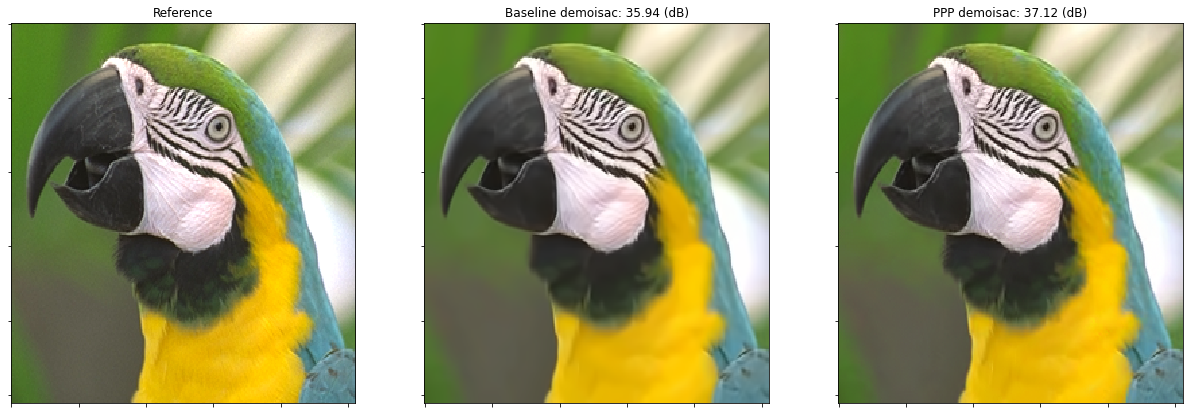

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(21, 7))
plot.imview(img, title="Reference", fig=fig, ax=ax[0])
plot.imview(imgb, title="Baseline demoisac: %.2f (dB)" % metric.psnr(img, imgb), fig=fig, ax=ax[1])
plot.imview(x, title="PPP demoisac: %.2f (dB)" % metric.psnr(img, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

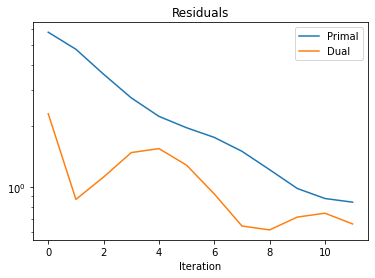

In [10]:
plot.plot(
    snp.vstack((hist.Primal_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)